# **Sentiments of Product Reviews**

**Team members:**\
Bryan Noel Salindeho\
Edmerson Low Soon Xiang\
Fiona Valentin Wironoto Susilo


## Step 1: Import libraries

In [35]:
# Core Python imports
import os
import re
import string
import json
import time
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# PyTorch & Hugging Face Transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Word embeddings using Gensim
from gensim.models import Word2Vec, FastText

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Evaluation and metrics
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 2: Mount Data from Google Drive

Connect to Google Drive

In [36]:
from google.colab import drive
drive.mount('/content/drive')

print("My Drive contents:")
!ls "/content/drive/My Drive/AI DM PROJECT"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
My Drive contents:
 bert_predictions_newest.csv		       IE4483.ipynb
'Copy of Copy of Copy of Final Model IE4483'  'IE4483 Mini Project.gdoc'
'Copy of Copy of Final Model IE4483'	      'IE4483 Mini Project Report.gdoc'
'Copy of Final Model IE4483'		       test.json
'Final Model IE4483'			       train.json
 Glove


Find Train Data

File founded
Data shape: (7401, 2)

First few rows:
                                             reviews  sentiments
0  I bought this belt for my daughter in-law for ...           1
1  The size was perfect and so was the color.  It...           1


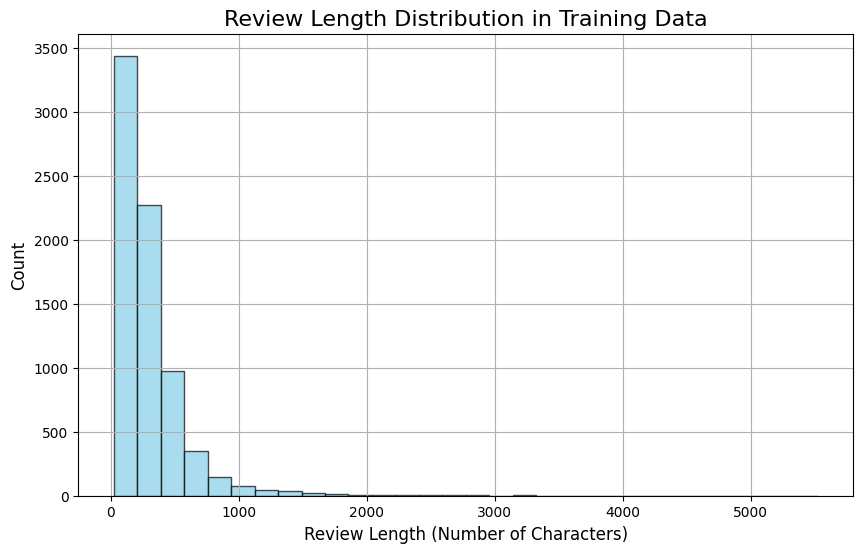


Review Length Statistics:
count    7401.000000
mean      300.926632
std       285.235376
min        24.000000
25%       133.000000
50%       223.000000
75%       373.000000
max      5525.000000
Name: review_length, dtype: float64


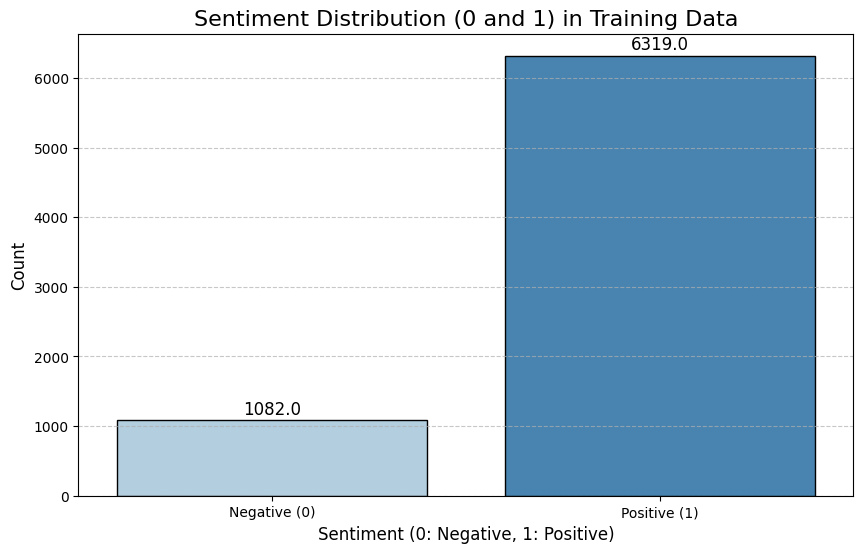


Sentiment Counts:
sentiments
1    6319
0    1082
Name: count, dtype: int64


In [37]:
train_path = '/content/drive/My Drive/AI DM PROJECT/train.json'
if os.path.exists(train_path):
  print("File founded")
  df = pd.read_json(train_path)
  print(f"Data shape: {df.shape}")
  print("\nFirst few rows:")
  print(df.head(2))
  train_df = df
else:
  print("File not founded")

if 'reviews' in train_df.columns:
    train_df['review_length'] = train_df['reviews'].apply(len)
    plt.figure(figsize=(10, 6))
    plt.hist(train_df['review_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Review Length Distribution in Training Data', fontsize=16)
    plt.xlabel('Review Length (Number of Characters)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True)
    plt.show()
    print("\nReview Length Statistics:")
    print(train_df['review_length'].describe())
else:
    print("The 'reviews' column is not present in the data.")

if 'sentiments' in train_df.columns:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=train_df, x='sentiments', palette='Blues', edgecolor='black')
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 8), textcoords='offset points')
    plt.title('Sentiment Distribution (0 and 1) in Training Data', fontsize=16)
    plt.xlabel('Sentiment (0: Negative, 1: Positive)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
    plt.show()
    sentiment_counts = train_df['sentiments'].value_counts()
    print("\nSentiment Counts:")
    print(sentiment_counts)
else:
    print("The 'sentiments' column is not present in the data.")

## Step 3: Clean Data


In [38]:
if train_df is not None:
    print("Data Info:")
    print(train_df.info())
    print("\nMissing Values:")
    print(train_df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7401 entries, 0 to 7400
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews        7401 non-null   object
 1   sentiments     7401 non-null   int64 
 2   review_length  7401 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 173.6+ KB
None

Missing Values:
reviews          0
sentiments       0
review_length    0
dtype: int64


In [39]:
class TextCleaner:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english')) - {
            'not', 'no', 'nor', 'very', 'too', 'but', 'however',
            'above', 'below', 'few', 'more', 'most', 'least',
            'should', 'would'
        }
        self.contractions = {
            "ain't": "is not", "aren't": "are not", "can't": "cannot",
            "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
            "don't": "do not", "hadn't": "had not", "hasn't": "has not",
            "haven't": "have not", "he'd": "he would", "he'll": "he will",
            "he's": "he is", "i'd": "i would", "i'll": "i will",
            "i'm": "i am", "i've": "i have", "isn't": "is not",
            "it's": "it is", "let's": "let us", "mightn't": "might not",
            "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
            "she'll": "she will", "she's": "she is", "shouldn't": "should not",
            "that's": "that is", "there's": "there is", "they'd": "they would",
            "they'll": "they will", "they're": "they are", "they've": "they have",
            "wasn't": "was not", "we'd": "we would", "we're": "we are",
            "weren't": "were not", "we've": "we have", "what'll": "what will",
            "what're": "what are", "what's": "what is", "what've": "what have",
            "where's": "where is", "who'd": "who would", "who'll": "who will",
            "who're": "who are", "who's": "who is", "who've": "who have",
            "won't": "will not", "wouldn't": "would not", "you'd": "you would",
            "you'll": "you will", "you're": "you are", "you've": "you have"
        }
        self.preserve_terms = {
            'x', 'xl', 'xxl', 'xs', 's', 'm', 'l', '3d', '2d',
            'uk', 'us', 'eu', 'mm', 'cm', 'in', 'v1', 'v2', 'v3'
        }

    def expand_contractions(self, text):
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text

    def clean_text(self, text, lemmatize=True):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = self.expand_contractions(text)
        text = re.sub(r'(\d+)x(\d+)', r'\1 by \2', text)
        text = re.sub(r'(\d+)ml', r'\1 ml', text)
        text = re.sub(r'(\d+)cm', r'\1 cm', text)
        text = re.sub(r'(\d+)mm', r'\1 mm', text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)
        text = text.translate(str.maketrans('', '', string.punctuation.replace('-', '')))
        words = word_tokenize(text)
        cleaned_words = []
        for word in words:
            if word.lower() in self.preserve_terms:
                cleaned_words.append(word)
                continue
            if word not in self.stop_words:
                if lemmatize:
                    word = self.lemmatizer.lemmatize(word)
                cleaned_words.append(word)
        text = ' '.join(cleaned_words)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def process_reviews(self, reviews, show_samples=5):
        cleaned_reviews = []
        for i, review in enumerate(reviews):
            cleaned = self.clean_text(review)
            cleaned_reviews.append(cleaned)
            if show_samples and i < show_samples:
                print(f"\nOriginal: {review[:100]}...")
                print(f"Cleaned:  {cleaned[:100]}...")
        return cleaned_reviews

cleaner = TextCleaner()

if 'train_df' in locals():
    print("\nProcessing training data:")
    train_df['cleaned_reviews'] = cleaner.process_reviews(train_df['reviews'])



Processing training data:

Original: I bought this belt for my daughter in-law for Christmas and she loved it...
Cleaned:  bought belt daughter in-law christmas loved...

Original: The size was perfect and so was the color.  It looked just like it did on the web page:)...
Cleaned:  size perfect color looked like web page...

Original: Fits and feels good, esp. for doing a swim race.  Highly recommend this.  

Be careful when wearing ...
Cleaned:  fit feel good esp swim race highly recommend careful wearing board short velcro zipper strap materia...

Original: These socks are absolutely the best. I take pilates classes and if it is hot your feet can slip off ...
Cleaned:  sock absolutely best take pilate class hot foot slip mat not good in middle side plankanyway sock ke...

Original: Thank you so much for the speedy delivery they came in time for the rehearsal dinner.  I loved the r...
Cleaned:  thank much speedy delivery came in time rehearsal dinner loved red silk neck tie really ma

## Step 4: Apply Vectorizer

In [40]:
class AdvancedTfidfExperiments:
    def __init__(self):
        self.results = {'feature_formats': {}}
        self.vectorizers = {
            'basic': self._create_basic_tfidf(),
            'advanced': self._create_advanced_tfidf()
        }
        self.feature_names = None

    def _create_basic_tfidf(self):
        return TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 3)
        )

    def _create_advanced_tfidf(self):
        preserve_words = {
            'not', 'no', 'nor', 'very', 'too', 'only', 'but',
            'more', 'most', 'least', 'better', 'worse',
            'good', 'bad', 'great', 'poor', 'excellent', 'terrible',
            'big', 'small', 'large', 'tiny', 'huge',
            'expensive', 'cheap', 'worth', 'price',
            'quality', 'size', 'color', 'fit', 'material'
        }

        stop_words = [w for w in stopwords.words('english') if w not in preserve_words]

        return Pipeline([
            ('tfidf', TfidfVectorizer(
                max_features=5000,
                ngram_range=(1, 2),
                max_df=0.7,
                min_df=5,
                stop_words=stop_words,
                sublinear_tf=True,
                norm='l2',
                smooth_idf=True,
                strip_accents='unicode',
                analyzer='word',
                token_pattern=r'(?u)\b[A-Za-z][A-Za-z0-9-_\.]{2,}\b'
            ))
        ])

    def _is_valid_feature(self, feature):
        if (len(feature) < 3 or
            len(feature) > 25 or
            re.match(r'^\d+$', feature) or
            sum(c.isdigit() for c in feature) > len(feature) * 0.5 or
            not any(c.isalpha() for c in feature)):
            return False
        return True

    def prepare_features(self, train_texts, val_texts, feature_type='advanced'):
        vectorizer = self.vectorizers[feature_type]
        X_train = vectorizer.fit_transform(train_texts).toarray()
        X_val = vectorizer.transform(val_texts).toarray()

        if hasattr(vectorizer, 'named_steps'):
            self.feature_names = vectorizer.named_steps['tfidf'].get_feature_names_out()
        else:
            self.feature_names = vectorizer.get_feature_names_out()

        return X_train, X_val

    def get_top_features(self, n_features=20, feature_type='advanced'):
        if not self.feature_names:
            return None

        vectorizer = self.vectorizers[feature_type]
        feature_scores = np.asarray(
            vectorizer.transform(self.last_train_texts).sum(axis=0)
        ).ravel()

        feature_scores = [(feature, score)
                         for feature, score in zip(self.feature_names, feature_scores)
                         if self._is_valid_feature(feature)]
        return sorted(feature_scores, key=lambda x: x[1], reverse=True)[:n_features]

    def visualize_features(self, n_features=20, feature_type='advanced'):
        top_features = self.get_top_features(n_features, feature_type)
        if not top_features:
            return

        plt.figure(figsize=(12, 8))
        features, scores = zip(*top_features)
        colors = sns.color_palette("husl", n_features)

        bars = plt.barh(features, scores, color=colors)
        plt.title(f'Top Features by TF-IDF Score ({feature_type})', fontsize=14, pad=20)
        plt.xlabel('TF-IDF Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)

        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2,
                    f'{width:.2f}', ha='left', va='center')

        plt.tight_layout()
        plt.show()

    def run_tfidf_analysis(self, train_df, test_df):
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            train_df['reviews'],
            train_df['sentiments'],
            test_size=0.2,
            random_state=42
        )
        return train_texts, val_texts, train_labels, val_labels


In [41]:
train_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/train.json')
test_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/test.json')
tfidf = AdvancedTfidfExperiments()
tfidf_experiments = tfidf.run_tfidf_analysis(train_df, test_df)

## Step 5: Implementing Bert Model

In [42]:
class BERTSentimentDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if isinstance(self.texts, pd.Series) else str(self.texts[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx])

        return item

class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes=2, dropout_rate=0.3):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

class BERTSentimentAnalyzer:
    def __init__(self, max_length=128, batch_size=32, epochs=10, learning_rate=2e-5,
                 dropout_rate=0.3, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = device
        self.model = BERTSentimentClassifier(dropout_rate=dropout_rate).to(device)
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'epoch_times': []
        }

    def train(self, train_texts, train_labels, val_texts, val_labels):
        train_dataset = BERTSentimentDataset(
            texts=train_texts,
            labels=train_labels,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )

        val_dataset = BERTSentimentDataset(
            texts=val_texts,
            labels=val_labels,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)

        for epoch in range(self.epochs):
            start_time = time.time()

            self.model.train()
            total_train_loss = 0
            train_correct = 0
            train_total = 0

            for batch in train_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_correct += (predicted == labels).sum().item()
                train_total += labels.size(0)

            self.model.eval()
            total_val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    outputs = self.model(input_ids, attention_mask)
                    loss = F.cross_entropy(outputs, labels)
                    total_val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == labels).sum().item()
                    val_total += labels.size(0)

            epoch_train_loss = total_train_loss / len(train_loader)
            epoch_val_loss = total_val_loss / len(val_loader)
            epoch_train_acc = (train_correct / train_total) * 100
            epoch_val_acc = (val_correct / val_total) * 100
            epoch_time = time.time() - start_time

            self.history['train_loss'].append(epoch_train_loss)
            self.history['val_loss'].append(epoch_val_loss)
            self.history['train_acc'].append(epoch_train_acc)
            self.history['val_acc'].append(epoch_val_acc)
            self.history['epoch_times'].append(epoch_time)

            print(f'Epoch [{epoch+1}/{self.epochs}], '
                  f'Train Loss: {epoch_train_loss:.4f}, '
                  f'Train Acc: {epoch_train_acc:.2f}%, '
                  f'Val Loss: {epoch_val_loss:.4f}, '
                  f'Val Acc: {epoch_val_acc:.2f}%')

    def predict(self, texts):
        test_dataset = BERTSentimentDataset(
            texts=texts,
            labels=None,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size)

        self.model.eval()
        predictions = []
        probabilities = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Predicting"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, dim=1)

                predictions.extend(preds.cpu().numpy())
                probabilities.extend(probs.cpu().numpy())

        return np.array(predictions), np.array(probabilities)


class BERTExperiments:
    def __init__(self):
        self.results = {}
        self.best_model = None

    def plot_training_progress(self, history, current_experiment):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss', marker='o')
        plt.plot(history['val_loss'], label='Val Loss', marker='s')
        plt.title(f'Loss Over Time ({current_experiment})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
        plt.plot(history['val_acc'], label='Val Accuracy', marker='s')
        plt.title(f'Accuracy Over Time ({current_experiment})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        print(f"\nCurrent metrics for {current_experiment}:")
        print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
        print(f"Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
        print(f"Final Val Accuracy: {history['val_acc'][-1]:.2f}%")
        print(f"Best Val Accuracy: {max(history['val_acc']):.2f}%")
        print(f"Best Val Loss: {min(history['val_loss']):.4f}")
        print("-" * 50)

    def run_bert_experiments(self, train_texts, train_labels, val_texts, val_labels):
        print("\nTesting BERT with best configuration...")
        model = BERTSentimentAnalyzer(
            max_length=128,
            batch_size=32,
            epochs=10,
            learning_rate=2e-5,
            dropout_rate=0.4
        )

        print("\nTraining BERT model...")
        model.train(train_texts, train_labels, val_texts, val_labels)
        self.plot_training_progress(model.history, "BERT Model")

        key = f"lr_{2e-5}"
        self.results[key] = {
            'final_accuracy': model.history['val_acc'][-1],
            'peak_accuracy': max(model.history['val_acc']),
            'peak_epoch': np.argmax(model.history['val_acc']) + 1,
            'history': model.history
        }

        self.best_model = model

    def save_predictions(self, test_df, output_path='bert_predictions.csv'):
        if self.best_model is None:
            raise ValueError("No trained model found. Run experiments first.")

        print("\nMaking predictions on test set...")
        predictions, probabilities = self.best_model.predict(test_df['reviews'])

        submission_df = pd.DataFrame({
            'reviews': test_df['reviews'],
            'predicted_sentiment': predictions,
            'negative_prob': probabilities[:, 0],
            'positive_prob': probabilities[:, 1]
        })

        submission_df.to_csv(output_path, index=False)
        print(f"\nPredictions saved to '{output_path}'")

        if self.best_model.history:
            self.plot_training_progress(self.best_model.history, "Final BERT Model")

        return submission_df

## Step 6: Predict on Test Data


Testing BERT with best configuration...

Training BERT model...
Epoch [1/10], Train Loss: 0.2242, Train Acc: 91.55%, Val Loss: 0.1362, Val Acc: 95.68%
Epoch [2/10], Train Loss: 0.1035, Train Acc: 96.37%, Val Loss: 0.1502, Val Acc: 95.27%
Epoch [3/10], Train Loss: 0.0477, Train Acc: 98.58%, Val Loss: 0.1428, Val Acc: 94.94%
Epoch [4/10], Train Loss: 0.0354, Train Acc: 99.02%, Val Loss: 0.1820, Val Acc: 95.41%
Epoch [5/10], Train Loss: 0.0199, Train Acc: 99.43%, Val Loss: 0.2109, Val Acc: 95.61%
Epoch [6/10], Train Loss: 0.0132, Train Acc: 99.71%, Val Loss: 0.2500, Val Acc: 95.54%
Epoch [7/10], Train Loss: 0.0150, Train Acc: 99.65%, Val Loss: 0.2096, Val Acc: 95.95%
Epoch [8/10], Train Loss: 0.0078, Train Acc: 99.85%, Val Loss: 0.1899, Val Acc: 96.02%
Epoch [9/10], Train Loss: 0.0093, Train Acc: 99.73%, Val Loss: 0.2282, Val Acc: 95.48%
Epoch [10/10], Train Loss: 0.0099, Train Acc: 99.65%, Val Loss: 0.2238, Val Acc: 95.07%


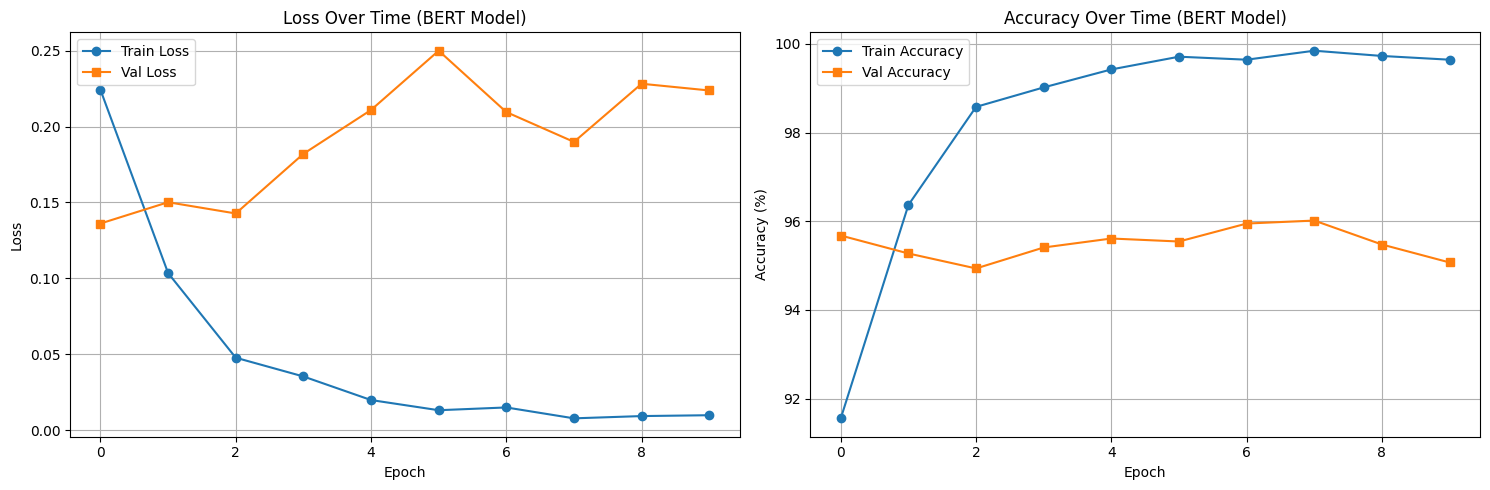


Current metrics for BERT Model:
Final Train Loss: 0.0099
Final Val Loss: 0.2238
Final Train Accuracy: 99.65%
Final Val Accuracy: 95.07%
Best Val Accuracy: 96.02%
Best Val Loss: 0.1362
--------------------------------------------------

Making predictions on test set...


Predicting: 100%|██████████| 58/58 [00:05<00:00, 10.81it/s]



Predictions saved to 'bert_predictions.csv'


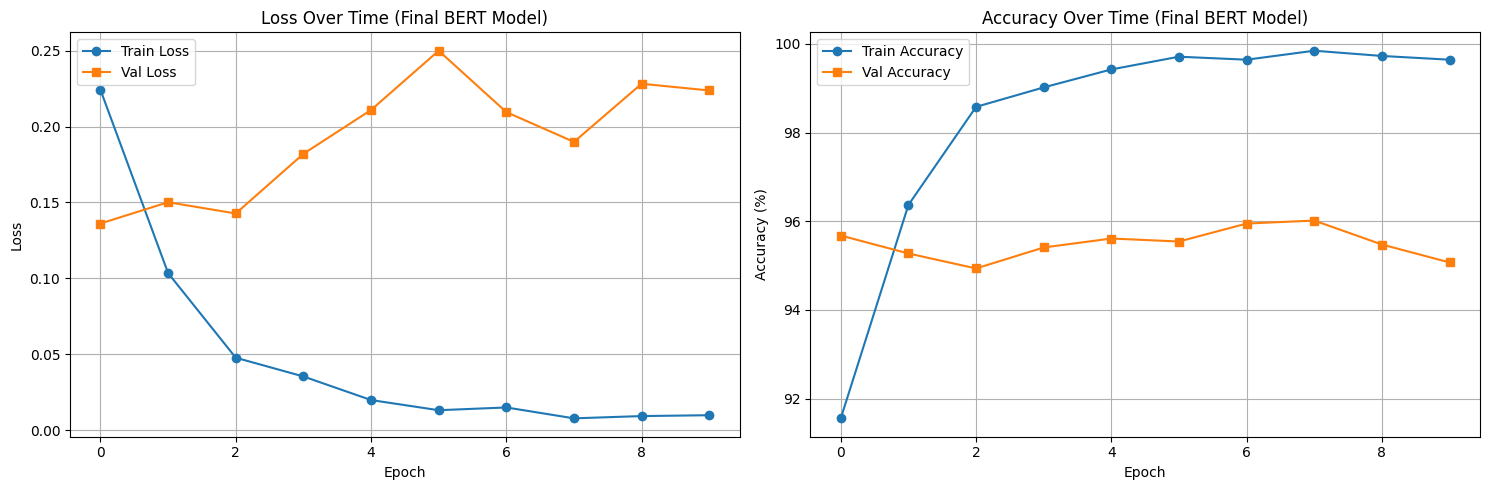


Current metrics for Final BERT Model:
Final Train Loss: 0.0099
Final Val Loss: 0.2238
Final Train Accuracy: 99.65%
Final Val Accuracy: 95.07%
Best Val Accuracy: 96.02%
Best Val Loss: 0.1362
--------------------------------------------------


In [43]:
bert_experiments = BERTExperiments()
bert_experiments.run_bert_experiments(train_texts, train_labels, val_texts, val_labels)

submission_df = bert_experiments.save_predictions(test_df)